# 🤖 **RPA** - 📧 Mailing Automático de Reporte de Tipos de Cambio 💵

## 📚 Instalación de librerías

Para instalar correctamente los paquetes necesarios, puedes utilizar el siguiente código quitando los numerales:

In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pandas
# !conda install --yes --prefix {sys.prefix} numpy
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --yes --prefix {sys.prefix} seaborn
# !conda install --yes --prefix {sys.prefix} selenium
# pip install webdriver-manager

Por otra parte, también vas a necesitar el chromedriver, o el driver necesario para tu navegador web. Este Software se descarga simplemente de la web oficial, no te preocupes. Una vez descargado, lo ubicas en la misma ruta que el script como es en el caso del presente notebook, o dentro del script puede informar la ruta de la siguiente manera, obviamente, quitándo los numerales:

In [2]:
# ruta_webdriver = r"C:\ruta\webdriver"
# driver = webdriver.Chrome(ruta_webdriver, options=chrome_options)

## 📚 Importación de librerías

In [3]:
# Manejo del tiempo para cronometrar el programa y manejar datos tipo fecha
import time
import datetime as dt
comienzo = time.perf_counter()

# Manejar datos y cálculos
import pandas as pd
import numpy as np

# Webscrapping
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Crear gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, MultipleLocator, AutoMinorLocator
import seaborn as sns

# No mostrar contraseña
from getpass import getpass

# Personalización del mail
import mimetypes
from email.message import EmailMessage
from email.mime.image import MIMEImage
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Seguridad para el mailing automático
import smtplib, ssl

# Personalizar df como tabla html
from tabulate import tabulate

In [4]:
# Función para eliminar el signo peso
def eliminar_peso(x):
    return x.lstrip('$')

# Función para reemplazar la coma de un string y convertirlo a número
def reemplazar_coma(x):
    return x.str.replace(',', '.').apply(pd.to_numeric)

## 📝 Importación de Excel acumulativo 

In [5]:
ruta_bbdd = r'Seguimiento Dólar Blue.csv'
df = pd.read_csv(ruta_bbdd, index_col=0)
df

,Fecha,Solidario,TCC_Blue,TCV_Blue,TCV_MEP,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,riesgo_pais,TCV MEP / TCV Billete,Solidario / TCV Blue,TCV MEP / TCV Blue,Variación TCV Blue,Variación TCV Euro,TCV Euro / TCC Blue %
0,01/08/23,503.13,555.0,560.0,511.01,274.5,287.5,275.75,276.15,603.0,609.0,5.33,154.88,1980.0,0.777426,-0.101554,-0.087482,0.018182,0.018395,0.087500
1,31/07/23,500.50,545.0,550.0,509.10,273.5,286.5,274.85,275.25,592.0,598.0,5.33,154.88,1960.0,0.776963,-0.090000,-0.074364,-0.001815,-0.001669,0.087273
2,28/07/23,497.88,546.0,551.0,518.79,272.0,285.0,273.30,273.70,593.0,599.0,5.08,154.88,2017.0,0.820316,-0.096407,-0.058457,-0.003617,-0.003328,0.087114
3,27/07/23,468.60,548.0,553.0,511.28,271.0,284.0,272.70,273.10,596.0,601.0,5.08,154.88,1991.0,0.800282,-0.152622,-0.075443,0.010969,0.010084,0.086799
4,26/07/23,468.60,542.0,547.0,517.61,271.0,284.0,272.10,272.50,589.0,595.0,5.08,154.88,1951.0,0.822570,-0.143327,-0.053729,0.020522,0.017094,0.087751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6347,17/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,758.0,NaN,NaN,NaN,0.000000,0.000000,NaN
6348,16/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,760.0,NaN,NaN,NaN,0.000000,0.000000,NaN
6349,15/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734.0,NaN,NaN,NaN,0.000000,0.000000,NaN
6350,14/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766.0,NaN,NaN,NaN,0.000000,0.000000,NaN


## 🤖 Ingreso a la web y toma de datos 

In [6]:
# Fuentes,usaremos las variables para ingresar a las webs y para citar las fuentes
web_dolarhoy = "https://dolarhoy.com/"
web_bna = "https://www.bna.com.ar/Personas"
web_ambito_mep = "https://www.ambito.com/contenidos/dolar-mep.html"
web_ambito_riesgo_pais = "https://www.ambito.com/contenidos/riesgo-pais-historico.html"
web_fed = "https://www.federalreserve.gov/releases/h15/"
web_bcra = "https://www.bcra.gob.ar/PublicacionesEstadisticas/Principales_variables.asp"
web_tiempo_financiero = "https://tiempofinanciero.com.ar/cotizaciones/euro-blue/"

In [7]:
# Ingreso a la web dolarhoy
driver = webdriver.Chrome("chromedriver", options=chrome_options)
driver.get(web_dolarhoy)

# Toma de datos mediante xpath
solidario = driver.find_element(
    "xpath",
    '//*[@id="home_0"]/div[2]/section/div/div/div/div[1]/div/div[2]/div[6]/div/div[2]/div[2]')
blue_tcc = driver.find_element(
    "xpath",
    '//*[@id="home_0"]/div[2]/section/div/div/div/div[1]/div/div[1]/div/div[1]/div[1]/div[2]')
blue_tcv = driver.find_element(
    "xpath",
    '//*[@id="home_0"]/div[2]/section/div/div/div/div[1]/div/div[1]/div/div[1]/div[2]/div[2]')

# Creación de fila nueva, la columna fecha toma la fecha de hoy y la convierte en serie de tiempo
# - dt.timedelta(days=1) para restar un día
dolar_hoy = pd.DataFrame(
    {"Fecha":dt.datetime.today(),
     "Solidario":solidario.text,
     "TCC_Blue":blue_tcc.text,
     "TCV_Blue":blue_tcv.text},
    index=[0])

dolar_hoy["Fecha"] = pd.to_datetime(dolar_hoy["Fecha"]).dt.strftime("%d/%m/%y")

# Eliminación de $
dolar_hoy.Solidario = dolar_hoy.Solidario.apply(eliminar_peso)
dolar_hoy.TCC_Blue = dolar_hoy.TCC_Blue.apply(eliminar_peso)
dolar_hoy.TCV_Blue = dolar_hoy.TCV_Blue.apply(eliminar_peso)

display(dolar_hoy)

driver.close()

,Fecha,Solidario,TCC_Blue,TCV_Blue
0,02/08/23,504.88,555,560


In [8]:
#ingreso a la web Banco Nación
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_bna)

billete_tcc = driver.find_element(
    "xpath",
    '//*[@id="billetes"]/table/tbody/tr[1]/td[2]')
billete_tcv = driver.find_element(
    "xpath",
    '//*[@id="billetes"]/table/tbody/tr[1]/td[3]')

bna = pd.DataFrame({
    "TCC_Billete":billete_tcc.text,
    "TCV_Billete":billete_tcv.text},
    index=[0])

#Cliquear botón que habilita el tipo de cambio divisas
driver.find_element(
    "xpath",
    '//*[@id="rightHome"]/div[1]/div/ul/li[2]/a').click()

#Esperar dos segundos para que aparezcan los elementos, wait.until no sirvió
time.sleep(2)

bna_tcc_divisas = driver.find_element(
    "xpath",
    '//*[@id="divisas"]/table/tbody/tr[1]/td[2]')
bna_tcv_divisas = driver.find_element(
    "xpath",
    '//*[@id="divisas"]/table/tbody/tr[1]/td[3]')
bna_divisas = pd.DataFrame(
    {"TCC_Divisas":bna_tcc_divisas.text,
    "TCV_Divisas":bna_tcv_divisas.text},
    index=[0])

bna = pd.concat([bna,bna_divisas], axis = 1)

#Reemplazar la , por . para que tome los decimales, sino lo toma como string
bna = bna.apply(reemplazar_coma)

display(bna)

driver.close()

,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas
0,275.5,288.5,277.0,277.4


In [9]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_ambito_mep)

time.sleep(2)

mep = driver.find_element(
    "xpath",
    '/html/body/main/div/div[1]/div[1]/div/div[2]/div[1]/div/div/div[2]/span[1]')

ambito = pd.DataFrame(
    {"TCV_MEP":mep.text},
    index=[0])

driver.get(web_ambito_riesgo_pais)
time.sleep(2)

riesgo_pais = driver.find_element(
    "xpath",
    '/html/body/main/div/div[1]/div[10]/table/tbody/tr[1]/td[2]')

riesgo_pais = pd.DataFrame(
    {"riesgo_pais":riesgo_pais.text},
    index=[0])

ambito = pd.concat([ambito,riesgo_pais],axis = 1)

ambito = ambito.apply(reemplazar_coma)

display(ambito)

driver.close()

,TCV_MEP,riesgo_pais
0,512.54,1990.0


In [10]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_tiempo_financiero)

time.sleep(2)

tcc_euro = driver.find_element(
    "xpath",
    '/html/body/div[2]/div/div/main/div/div/div/div/div[1]/table/tbody/tr/td[2]')

tcv_euro =  driver.find_element(
    "xpath",
    '/html/body/div[2]/div/div/main/div/div/div/div/div[1]/table/tbody/tr/td[3]')

euro = pd.DataFrame(
    {"TCC_Euro":tcc_euro.text,
    "TCV_Euro":tcv_euro.text},
    index=[0])

euro.TCC_Euro = euro.TCC_Euro.apply(eliminar_peso)
euro.TCV_Euro = euro.TCV_Euro.apply(eliminar_peso)

display(euro)

driver.close()

,TCC_Euro,TCV_Euro
0,603,609


In [11]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_fed)

fed_tea = driver.find_element(
    "xpath",
    '/html/body/div[3]/div[6]/table/tbody/tr[1]/td[5]')
time.sleep(2)

fed_tea = pd.DataFrame(
{"fed_tea":fed_tea.text},
index=[0])

time.sleep(2)

driver.get(web_bcra)
time.sleep(2)

bcra_tea = driver.find_element(
    "xpath",
    '/html/body/div/div[2]/div/div/div/div/table/tbody/tr[8]/td[3]')
time.sleep(2)

bcra_tea = pd.DataFrame(
    {"bcra_tea":bcra_tea.text},
    index=[0])

tasas = pd.concat([fed_tea,bcra_tea], axis=1).apply(reemplazar_coma)
display(tasas)

driver.close()

,fed_tea,bcra_tea
0,5.33,154.88


In [12]:
#nueva fila final con todos los datos tomados
fila_nueva = [dolar_hoy, ambito, bna, euro, tasas]
fila_nueva = pd.concat(fila_nueva, axis=1)
fila_nueva_cols = [
    'Fecha',
    'Solidario',
    'TCC_Blue',
    'TCV_Blue',
    'TCV_MEP',
    'TCC_Billete',
    'TCV_Billete',
    'TCC_Divisas',
    'TCV_Divisas',
    'TCC_Euro',
    'TCV_Euro',
    'fed_tea',
    'bcra_tea',
    'riesgo_pais'
]

fila_nueva = fila_nueva[fila_nueva_cols]
fila_nueva

,Fecha,Solidario,TCC_Blue,TCV_Blue,TCV_MEP,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,riesgo_pais
0,02/08/23,504.88,555,560,512.54,275.5,288.5,277.0,277.4,603,609,5.33,154.88,1990.0


## 🖥️ Concatenado de la nueva fila en el DataFrame acumulado 

In [13]:
# Concatenado de la fila nueva
df = pd.concat([
    fila_nueva,
    df.loc[:]
]).reset_index(drop=True)

In [14]:
# Pasar todo a número, ya que el tipo de dato al haber tenido un signo $ no es un número
df[[
    "TCC_Blue",
    "TCV_Blue",
    "Solidario",
    "TCV_MEP",
    "TCC_Billete",
    "TCV_Billete",
    "TCV_Divisas",
    "TCC_Euro",
    "TCV_Euro"
    ]
] = df[[
    "TCC_Blue",
    "TCV_Blue",
    "Solidario",
    "TCV_MEP",
    "TCC_Billete",
    "TCV_Billete",
    "TCV_Divisas",
    "TCC_Euro",
    "TCV_Euro"
    ]
].astype(float)

In [15]:
# Bajo paridad de tasas de interés de Irving Fisher
bcra_tea_numerador = 1 + (float(df["bcra_tea"].iloc[0])/100)
fed_tea_denominador = 1 + (float(df["fed_tea"].iloc[0])/100)
division = bcra_tea_numerador / fed_tea_denominador
fwd_oficial = float(df["TCV_Billete"].iloc[0]) * division
fwd_blue = float(df["TCV_Blue"].iloc[0]) * division

In [16]:
# Crear columnas de cálculo de brechas y variación del día
df["TCV MEP / TCV Billete"] = df["TCV_MEP"]/df["TCV_Billete"]-1
df["Solidario / TCV Blue"] = df["Solidario"]/df["TCV_Blue"]-1
df["TCV MEP / TCV Blue"] = df["TCV_MEP"]/df["TCV_Blue"]-1
df["Variación TCV Blue"] = df["TCV_Blue"].pct_change(periods=-1)
df["Variación TCV Blue"].fillna(0, inplace=True)
df["Variación TCV Euro"] = df["TCV_Euro"].pct_change(periods=-1)
df["Variación TCV Euro"].fillna(0, inplace=True)
df["TCV Euro / TCC Blue %"] = df["TCV_Euro"]/df["TCV_Blue"]-1

# Eliminación de duplicados, por si se usa dos veces el mismo día no duplique datos
df = df.drop_duplicates(
    subset="Fecha",
    keep="last",
    inplace=False,
    ignore_index=False
)

# Formateo el despliegue para que me traiga % y 2 decimales, de manera que quede un output cool
planilla = df.head(10).style.format(
    {"Solidario": "{:.2f}",
     "TCV_MEP": "{:2}",
     "TCC_Blue": "{:.0f}",
     "TCV_Blue": "{:.0f}",
     "TCC_Billete": "{:2}",
     "TCV_Billete": "{:2}",
     "TCC_Divisas": "{:3}",
     "TCV_Divisas": "{:3}",
     "TCC_Euro": "{:.0f}",
     "TCV_Euro": "{:.0f}",
     "riesgo_pais": "{:.0f}",
     "fed_tea":"{:.2f}",
     "bcra_tea":"{:.2f}",
     "TCV MEP / TCV Billete": "{:.2%}",
     "Solidario / TCV Blue": "{:.2%}",
     "TCV MEP / TCV_Blue": "{:.2%}",
     "Variación TCV Blue": "{:.2%}",
     "Variación TCV Euro": "{:.2%}",
     "TCV Euro / TCC Blue %": "{:.2%}"
     }
)

display(planilla)

print(f"""
💵Resumen diario🤖:

Costo comprar USD 200 blue: $ {(float(df["TCV_Blue"].iloc[0] * 200)):,.0f}
Costo comprar USD 200 oficiales con impuestos: $ {(float(df["Solidario"].iloc[0] * 200)):,.2f}
La diferencia es de: $ {(float(df["TCV_Blue"].iloc[0] * 200 - df["Solidario"].iloc[0] * 200)):,.2f}
La brecha entre solidario y blue es: {float((1 - df["Solidario"].iloc[0] / df["TCV_Blue"].iloc[0]) * 100):.2f}%
El dólar solidario varió: {float(((df["Solidario"].iloc[0] / df["Solidario"].iloc[1] - 1) * 100)):.2f}%
El dólar blue varió: {float(((df["TCV_Blue"].iloc[0] / df["TCV_Blue"].iloc[1] - 1) * 100)):.2f}%
El dólar divisas varió: {float(((df["TCV_Divisas"].iloc[0] / df["TCV_Divisas"].iloc[1] - 1) * 100)):.2f}%
Entre euro blue y dólar blue hay una brecha de:</b> {df["TCV_Blue"].iloc[0] / float((1 - df["TCV_Euro"].iloc[0]) * 100):.2f}
El euro subió un: {float(((df["TCV_Euro"].iloc[0] / df["TCV_Euro"].iloc[1] - 1) * 100)):.2f}%
El riesgo país hoy es de: {(float(df["riesgo_pais"].iloc[0])):,.0f}, es decir que Argentina debe pagar un {(float(df["riesgo_pais"].iloc[0] / 100)):.2f}% por arriba de la tasa que paga Estados Unidos.
El valor futuro según paridad de tasas de interés oficial es: {fwd_oficial:,.2f}
El valor futuro según paridad de tasas de interés blue es: {fwd_blue:,.2f}""")

,Fecha,Solidario,TCC_Blue,TCV_Blue,TCV_MEP,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,riesgo_pais,TCV MEP / TCV Billete,Solidario / TCV Blue,TCV MEP / TCV Blue,Variación TCV Blue,Variación TCV Euro,TCV Euro / TCC Blue %
0,02/08/23,504.88,555,560,512.54,275.5,288.5,277.0,277.4,603,609,5.33,154.88,1990,77.66%,-9.84%,-0.084750,0.00%,0.00%,8.75%
1,01/08/23,503.13,555,560,511.01,274.5,287.5,275.75,276.15,603,609,5.33,154.88,1980,77.74%,-10.16%,-0.087482,1.82%,1.84%,8.75%
2,31/07/23,500.50,545,550,509.1,273.5,286.5,274.85,275.25,592,598,5.33,154.88,1960,77.70%,-9.00%,-0.074364,-0.18%,-0.17%,8.73%
3,28/07/23,497.88,546,551,518.79,272.0,285.0,273.3,273.7,593,599,5.08,154.88,2017,82.03%,-9.64%,-0.058457,-0.36%,-0.33%,8.71%
4,27/07/23,468.60,548,553,511.28,271.0,284.0,272.7,273.1,596,601,5.08,154.88,1991,80.03%,-15.26%,-0.075443,1.10%,1.01%,8.68%
5,26/07/23,468.60,542,547,517.61,271.0,284.0,272.1,272.5,589,595,5.08,154.88,1951,82.26%,-14.33%,-0.053729,2.05%,1.71%,8.78%
6,25/07/23,467.77,531,536,506.58,270.5,283.5,271.2,271.6,474,585,5.08,154.88,1960,78.69%,-12.73%,-0.054888,-2.90%,-2.17%,9.14%
7,24/07/23,467.77,547,552,497.07,270.5,283.5,270.6,271.0,592,598,5.08,154.88,2021,75.33%,-15.26%,-0.099511,4.55%,4.18%,8.33%
8,21/07/23,464.47,523,528,499.09,268.5,281.5,269.05,269.45,568,574,5.08,154.88,2038,77.30%,-12.03%,-0.054754,0.57%,0.53%,8.71%
9,20/07/23,462.00,520,525,495.84,267.0,280.0,268.3,268.7,565,571,5.08,154.88,2064,77.09%,-12.00%,-0.055543,0.00%,-0.35%,8.76%



💵Resumen diario🤖:

Costo comprar USD 200 blue: $ 112,000
Costo comprar USD 200 oficiales con impuestos: $ 100,976.00
La diferencia es de: $ 11,024.00
La brecha entre solidario y blue es: 9.84%
El dólar solidario varió: 0.35%
El dólar blue varió: 0.00%
El dólar divisas varió: 0.45%
Entre euro blue y dólar blue hay una brecha de:</b> -0.01
El euro subió un: 0.00%
El riesgo país hoy es de: 1,990, es decir que Argentina debe pagar un 19.90% por arriba de la tasa que paga Estados Unidos.
El valor futuro según paridad de tasas de interés oficial es: 698.12
El valor futuro según paridad de tasas de interés blue es: 1,355.10


## 💾 Exportar a CSV

In [17]:
df.to_csv(ruta_bbdd)

## 📈 Gráficos para adjuntar en el mail

In [18]:
cotizaciones_a_mostrar = 25

# Copia del dataframe, para no reemplazarlo
data = df.copy()

# Tomamos las primeras filas que querramos mostrar y las primeras 14 columnas, es decir, sin variaciones
data = data.iloc[:cotizaciones_a_mostrar,:14]

# Damos vuelta el dataframe sólo para los gráficos
# Si no lo damos vuelta, los gráficos van a empzar de hoy hacia atrás
data = data.iloc[::-1]

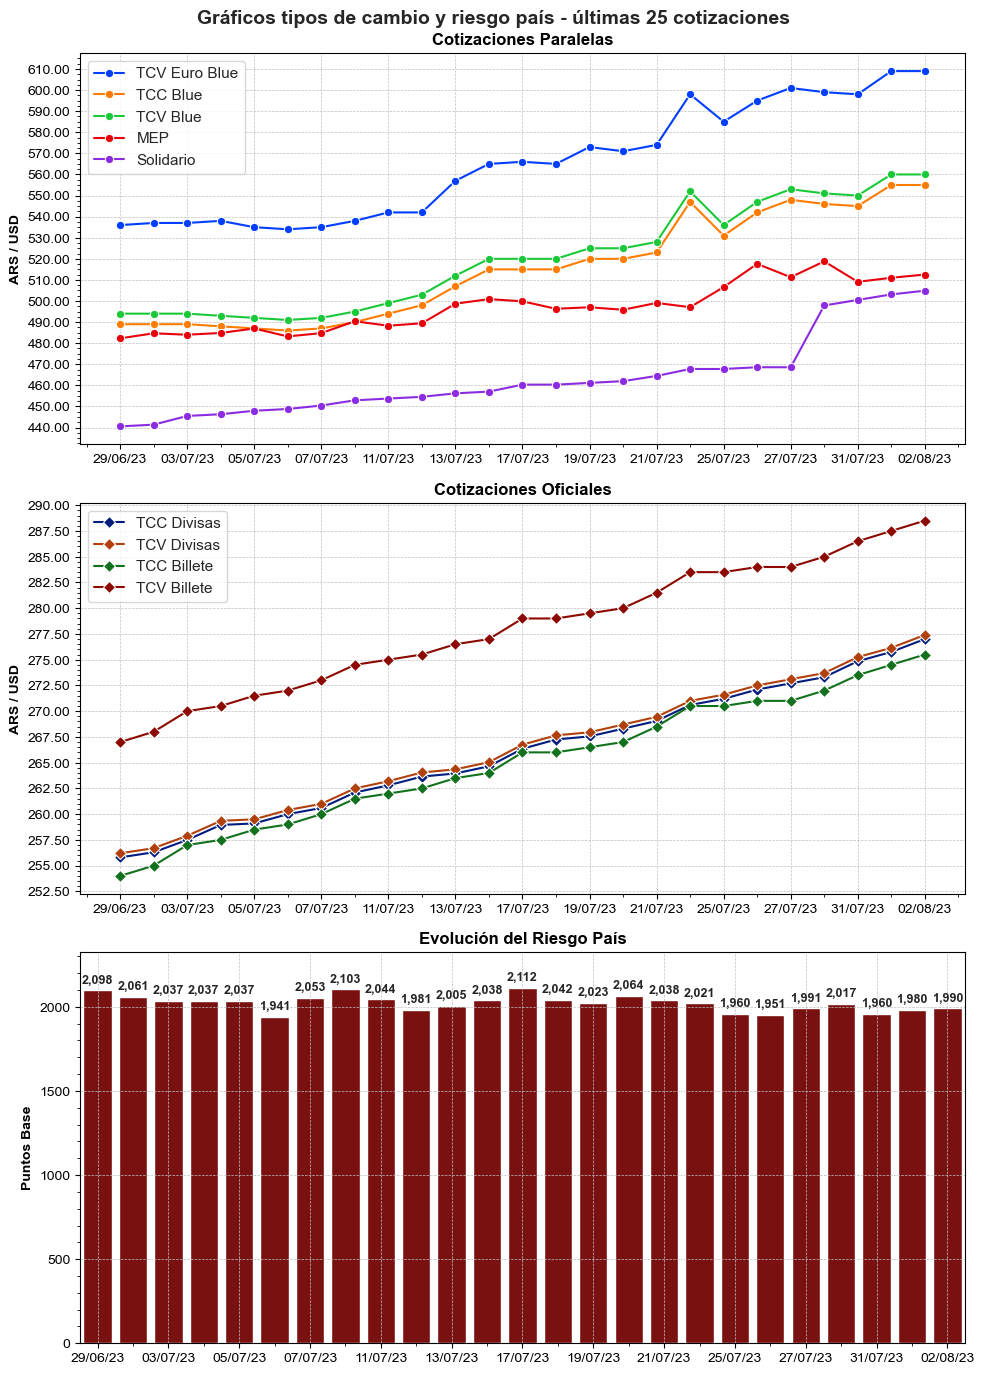

In [19]:
# Creo un subplot de 3 gráficos verticales
fig, ax = plt.subplots(
    3, 1,
    figsize=(10, 14),
    sharex=False
)

# Estilo de gráfico, con ticks en X e Y
sns.set(style="ticks")

titulos = [
    "Cotizaciones Paralelas",
    "Cotizaciones Oficiales",
    "Evolución del Riesgo País",
]

ax0_palette = sns.color_palette("bright")

ax0_columns = [
    "TCV_Euro",
    "TCC_Blue",
    "TCV_Blue",
    "TCV_MEP",
    "Solidario"
]
ax0_labels = [
    "TCV Euro Blue",
    "TCC Blue",
    "TCV Blue",
    "MEP",
    "Solidario"
]

# Títulos general y para cada gráfico
fig.suptitle(
    f"Gráficos tipos de cambio y riesgo país - últimas {cotizaciones_a_mostrar} cotizaciones",
    fontweight="bold",
    fontsize=14
)
for i, titulo in enumerate(titulos):
    ax[i].set_title(
        titulo,
        fontweight="bold",
        fontsize=12
    )

for i, column in enumerate(ax0_columns):
    sns.lineplot(
        x="Fecha",
        y=column,
        data=data,
        label=ax0_labels[i],
        color=ax0_palette[i],
        marker="o",
        ax=ax[0],
    )

# Gráfico de cotizaciones oficiales
ax1_palette = sns.color_palette("dark")
ax1_columns = [
    "TCC_Divisas",
    "TCV_Divisas",
    "TCC_Billete",
    "TCV_Billete"
]
ax1_labels = [
    "TCC Divisas",
    "TCV Divisas",
    "TCC Billete",
    "TCV Billete"
]
for i, column in enumerate(ax1_columns):
    sns.lineplot(
        x="Fecha",
        y=column,
        data=data,
        label=ax1_labels[i],
        color=ax1_palette[i],
        marker="D",
        ax=ax[1],
    )

# Gráfico de barras del riesgo país
sns.barplot(
    x="Fecha",
    y="riesgo_pais",
    data=data,
    label="Riesgo País",
    color="darkred",
    ax=ax[2],
)

# Agregamos etiquetas de datos a las barras
for i, bar in enumerate(ax[2].containers[0].get_children()[-len(data.riesgo_pais) :]):
    height = bar.get_height()
    ax[2].annotate(
        f"{height:,.0f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontproperties=fm.FontProperties(weight="bold", size=9),
    )

# Consolidate the formatting of x-axis
for axis in ax:
    axis.set_xlabel("")
    axis.xaxis.set_major_locator(MultipleLocator(2))
    axis.xaxis.set_minor_locator(MultipleLocator(1))

# y separador de miles, por si la inflación se va demasiado, ya estoy adelantado
def formato(x, pos):
    return "{:,.2f}".format(x)
for i in range(2):
    ax[i].yaxis.set_major_formatter(formato)

# Títulos y ticks eje Y
y_labels = ["ARS / USD", "ARS / USD", "Puntos Base"]
y_major_locators = [
    MultipleLocator(10),
    MultipleLocator(2.5),
    MultipleLocator(500)
]
y_minor_locators = [
    MultipleLocator(2.5),
    MultipleLocator(0.5),
    MultipleLocator(100)
]
for i in range(3):
    ax[i].set_ylabel(y_labels[i], fontweight="bold")
    ax[i].yaxis.set_major_locator(y_major_locators[i])
    ax[i].yaxis.set_minor_locator(y_minor_locators[i])

# Límites eje Y
ax[2].set_ylim([0, data.riesgo_pais.max() * 1.1])

# Le damos estilo al grid del fondo
grid_estilo = {"color": "silver", "linestyle": "--", "linewidth": 0.5}
for axis in ax:
    axis.grid(**grid_estilo)

# Guardamos el gráfico como imagen .jpg para enviarla por mail
fig.tight_layout(pad=1)
graficos_jpg = "Gráficos Tipos de Cambios y Riesgo País.jpg"
plt.savefig(graficos_jpg)

## 📮 Mailing automático

In [ ]:
# Declaración de variables
# para que funcione tu contraseña de gmail, tenés que tener una contraseña para app
# si no tenés, se crea en esta página myaccount.google.com
email_sender = input("Tipeá tu usuario de gmail:")
email_password = getpass("Tipeá tu contraseña:")

email_receiver = [
    "martinezmauroezequiel@gmail.com",
    "siquilacamila@gmail.com",
    "maximo.garcia@grupohst.com",
    "garciiamaximo@gmail.com",
    "fretesricardo20@gmail.com",
    "danielignacio605@gmail.com",
    "alannicolassauer@hotmail.com",
    "djacue@gmail.com",
    "rochita.sp@hotmail.com",
    "renzo.deleo@gmail.com",
    "m.cardozo@wega.com.ar",
    "facundoezequiel_andrada@hotmail.com",
    "gonzaloeorellana@gmail.com",
    "lsantanasilva@bybglobalcorp.com",
    "mariano_danze@hotmail.com",
    "duartecami28@gmail.com",
    "sscunico@gmail.com",
    "msguerrieri@bybglobalcorp.com",
    "eveiguelo@yahoo.com.ar",
    "juanmeils@hotmail.com",
    "agalean7@gmail.com",
    "apavlovsky@bybglobalcorp.com",
    "bibybsa@gmail.com",
    "mmartinez@bybglobalcorp.com"
]

# email_receiver = email_sender

# Tabular los días a mostrar del dataframe para que se vea en el cuerpo del mail
cotizaciones = [
    "Fecha",
    "Solidario",
    "tccblue",
    "tcvblue",
    "MEP",
    "tccBillete",
    "tcvBillete",
    "tccDivisas",
    "tcvDivisas",
    "tccEuros",
    "tcvEuros",
    "FEDtea",
    "BCRAtea",
    "RiesgoPaís"
]

# Valores correspondientes a los últimos 9 días, 9 columnas
valores = df.iloc[:cotizaciones_a_mostrar, :14].values.tolist()
tabla_coti = tabulate(
    valores,
    headers=cotizaciones,
    tablefmt = "html",
    numalign="center",
    floatfmt=".2f"
)

# Encabezados para tabular últimos 10 días del df y ponerlo en el cuerpo
variaciones = [
    "MEP/TCV_Billete",
    "Solidario/TCV_Blue",
    "MEP/TCV_Blue",
    "Variación_Blue",
    "Variación_Euro",
    "Euro_Blue/Dólar_Blue"
]
# Valores correspondientes a los últimos 10 días, 14 columnas
valores = df.iloc[:cotizaciones_a_mostrar, 14:].values.tolist()
tabla_vari = tabulate(
    valores,
    headers=variaciones,
    tablefmt="html",
    numalign="center",
    floatfmt=".2%"
)

# Cuerpo del texto con código html
html = f"""<!DOCTYPE html>
<html lang="es">
   <head>
      <meta charset="UTF-8">
      <meta http-equiv="X-UA-Compatible" content="IE=edge">
      <meta name="viewport" content="width=device-width, initial-scale=1.0">
   </head>
   <body>
      <p> 💵 <b><u>Resumen diario:</u></b> <br></p>
      <p>
         <b>Costo comprar USD 200 blue:</b> $ {(float(df["TCV_Blue"].iloc[0] * 200)):,.2f} <br>
         <b>Costo comprar USD 200 oficiales con impuestos:</b> $ {(float(df["Solidario"].iloc[0] * 200)):,.2f}<br>
         <b>La diferencia es de:</b> $ {(float(df["TCV_Blue"].iloc[0] * 200 - df["Solidario"].iloc[0] * 200)):,.2f}<br><br>
         <b>La brecha entre solidario y blue es:</b> {float((1 - df["Solidario"].iloc[0] / df["TCV_Blue"].iloc[0]) * 100):.2f}%<br>
         <b>El dólar solidario varió:</b> {float(((df["Solidario"].iloc[0] / df["Solidario"].iloc[1] - 1) * 100)):.2f}%<br>
         <b>El dólar blue varió:</b> {float(((df["TCV_Blue"].iloc[0] / df["TCV_Blue"].iloc[1] - 1) * 100)):.2f}%<br>
         <b>El dólar divisas varió:</b> {float(((df["TCV_Divisas"].iloc[0] / df["TCV_Divisas"].iloc[1] - 1) * 100)):.2f}%<br><br>
         <b>El euro subió un:</b> {float(((df["TCV_Euro"].iloc[0] / df["TCV_Euro"].iloc[1] - 1) * 100)):.2f}%<br>
         <b>Entre euro blue y dólar blue hay una brecha de:</b> $ {df["TCV_Blue"].iloc[0] / float((1 - df["TCV_Euro"].iloc[0]) * 100):.2f}%<br><br>
         <b>El valor del dólar oficial futuro según paridad de tasas de interés es:</b> $ {fwd_oficial:,.2f}<br>
         <b>El valor del dólar blue futuro según paridad de tasas de interés es:</b> ${fwd_blue:,.2f}<br>
         <b>El riesgo país hoy es de:</b> {(float(df["riesgo_pais"].iloc[0])):,.0f}, es decir que Argentina debe pagar un {(float(df["riesgo_pais"].iloc[0] / 100)):.2f}% por arriba de la tasa que paga Estados Unidos.
      </p>
      <img src='cid:image1'>
      <p>Las siguientes tablas muestran las últimas {cotizaciones_a_mostrar} cotizaciones de dólares, euro, riesgo país y TEA del BCRA 🇦🇷 y TEA de la FED 🇺🇸.<br>
      Analizalas mientras te cebás unos mates 🧉:<br>
      </p>
      {tabla_coti}<br>
      {tabla_vari}<br>
      <p><b><u>Las fuentes consultadas fueron:</u>
      <b><br>Cotizaciones oficiales: </b>{web_bna}
      <b><br>Cotizaciones paralelas y Solidario: </b>{web_dolarhoy}
      <b><br>Cotización Dólar MEP: </b>{web_ambito_mep}
      <b><br>Riesgo País: </b>{web_ambito_riesgo_pais}
      <b><br>Cotización Euro Blue: </b>{web_tiempo_financiero}
      <b><br>Tasa Efectiva Anual EEUU (FED): </b>{web_fed}
      <b><br>Tasa Efectiva Anual Argentina (BCRA): </b>{web_bcra}<br>
      </p>
      <p>
         Muchas gracias por leer,<br>
         Ojalá te sirva,<br><br>
      <p> 
         <i>🤖 Este es un mail automático creado por <b>Mauro E. Martinez</b>, comunicarse mediante correo martinezmauroezequiel@gmail.com ante cualquier duda, feedback o desuscripción.
         <br>En Linkedin encontrá mi historial laboral, académico y mis aportes en datos y comercio internacional: </i><b>linkedin.com/in/mauroemartinez/</b>
         <br><i>Visitá mi GitHub donde verás mis proyectos. ¡Incluso este!: </i><b>https://github.com/mauroemartinez/</b>
      </p>
      </p>  
   </body>
</html>"""

# Crear el objeto MIMEMultipart y asignarle los campos
# A los receptores los ubico en Cco para que no se vean entre sí
em = MIMEMultipart('related')
em['From'] = email_sender
em["To"] = email_sender
em['Cco'] = ', '.join(email_receiver)
em["Subject"] = f"📈 Reporte automático de tipos de cambio  💵 - {dt.datetime.today():%d-%m-%Y} 📧"

# Crear el cuerpo del mensaje como un objeto MIMEText y adjuntarlo al objeto MIMEMultipart
body = MIMEText(html, 'html')
em.attach(body)

# Tomar la imagen y crear un MIMEImage a adjuntar
with open(graficos_jpg, 'rb') as fp:
    msgImage = MIMEImage(fp.read())
# Definir ID de la imagen, tal como en el html, adjuntar
msgImage.add_header('Content-ID', '<image1>')
msgImage.add_header('Content-Disposition', 'attachment', filename = graficos_jpg)
em.attach(msgImage)

# # Abrir y adjuntar el .csv
# bd_filename = 'Seguimiento Dólar Blue.csv'
# with open(bd_filename, 'r') as fp:
#     bd_data = fp.read()
# bd = MIMEText(bd_data, 'csv')
# bd.add_header('Content-Disposition', 'attachment', filename=bd_filename)
# em.attach(bd)

# Crear un contexto SSL y establecer una conexión SMTP segura con el servidor de correo
context = ssl.create_default_context()
with smtplib.SMTP_SSL(
    "smtp.gmail.com",
    465,
    context=context) as smtp:
    smtp.login(
        email_sender,
        email_password
        )
    smtp.sendmail(
        email_sender,
        email_receiver,
        em.as_string()
        )

# # para outlook
# context = ssl.create_default_context()
# with smtplib.SMTP("smtp-mail.outlook.com", 587) as server:
#     server.ehlo()
#     server.starttls(context=context)
#     server.ehlo()
#     server.login(email_sender, email_password)
#     server.sendmail(email_sender, email_receiver, em.as_string())

print(f"La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos")